In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

## Since fasttext had better embeddings let's test that first

In [2]:
# Setting up torch
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [3]:
df1 = pd.read_csv("../Data/fasttext_scratch_dataset.csv")

# Splitting the dataset
X = df1.drop("Target", axis=1)
y = df1["Target"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,shuffle=True, random_state=42)

# Converting to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Print tensor shapes
print("X_train shape:", X_train_tensor.shape) 
print("y_train shape:", y_train_tensor.shape)


X_train shape: torch.Size([3765, 300])
y_train shape: torch.Size([3765])


In [4]:
# Print tensor shapes
print("X_test shape:", X_test_tensor.shape) 
print("y_test shape:", y_test_tensor.shape)

X_test shape: torch.Size([942, 300])
y_test shape: torch.Size([942])


In [5]:
# Data prepration for PyTorch

from torch.utils.data import DataLoader, TensorDataset

# Combine embeddings and labels into TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Batch size adjustable
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
# Defining Network

import torch.nn as nn
import torch.optim as optim

# Simple feedforward neural network
class DNN_Classifier(nn.Module):
    def __init__(self, input_dim, output_dim,input_neurons=64, hidden1_neurons=32, dropout1_rate=0.3, dropout2_rate=0.3):
        super(DNN_Classifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, input_neurons)
        self.bn1 = nn.BatchNorm1d(input_neurons)
        self.dropout1 = nn.Dropout(dropout1_rate)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(input_neurons, hidden1_neurons)
        self.bn2 = nn.BatchNorm1d(hidden1_neurons)
        self.dropout2 = nn.Dropout(dropout2_rate)
        self.fc3 = nn.Linear(hidden1_neurons, output_dim) 
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Initialization
input_dim = 300       # Dimension of embeddings
output_dim = len(set(y_train_tensor.numpy()))  # Number of unique classes
print(output_dim)

model = DNN_Classifier(input_dim, output_dim)
print(model)

6
DNN_Classifier(
  (fc1): Linear(in_features=300, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=32, out_features=6, bias=True)
)


## Training

In [7]:
# loss function and Adam Optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.0001 )  # Adam optimizer

In [8]:
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay

def model_train(model, criterion, optimizer, train_loader, test_loader, epochs=20):
  # Initialize lists to store training and testing losses
  train_losses = []
  test_losses = []

  # Training and evaluation loop
  for epoch in range(epochs):
      # Training phase
      model.train()
      train_loss = 0
      for X_batch, y_batch in train_loader:
          X_batch, y_batch = X_batch.to(device), y_batch.to(device) 
          optimizer.zero_grad()
          outputs = model(X_batch)
          loss = criterion(outputs, y_batch.long())  # Ensure labels are long type
          loss.backward()
          # Prevent exploading gradients by clipping
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
          optimizer.step()
          train_loss += loss.item()
      train_loss /= len(train_loader)  # Average loss for training
      train_losses.append(train_loss)

      # Testing phase
      model.eval()
      test_loss = 0
      with torch.no_grad():
          for X_batch, y_batch in test_loader:
              X_batch, y_batch = X_batch.to(device), y_batch.to(device) 
              outputs = model(X_batch)
              loss = criterion(outputs, y_batch.long())
              test_loss += loss.item()
      test_loss /= len(test_loader)  # Average loss for testing
      test_losses.append(test_loss)

      # # Update learning rate based on test loss
      # scheduler.step(test_loss)

      # Print losses for the epoch
      print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

  # Plot the learning curve
  plt.figure(figsize=(10, 6))
  plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
  plt.plot(range(1, epochs+1), test_losses, label='Testing Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Learning Curve')
  plt.legend()
  plt.grid()
  plt.show()

def evaluate_model(model, test_loader):
    """
    Evaluate the model on the test set, generate a classification report, plot the ROC curve,
    and display the confusion matrix.

    Parameters:
        model: Trained PyTorch model
        test_loader: DataLoader for the test set

    Returns:
        None
    """
    model.eval()  # Set model to evaluation mode
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device) 
            outputs = model(X_batch)  # Model predictions
            probs = torch.softmax(outputs, dim=1)  # Convert to probabilities
            preds = torch.argmax(probs, dim=1)  # Predicted classes

            all_labels.extend(y_batch.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Convert to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Determine the number of classes
    num_classes = all_probs.shape[1]

    # Classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds))

    # ROC Curve for each class
    plt.figure(figsize=(10, 6))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(all_labels == i, all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    # Random classifier line
    plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(all_labels))
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix')
    plt.show()

Epoch 1/300, Train Loss: 1.6451, Test Loss: 1.4616
Epoch 2/300, Train Loss: 1.4411, Test Loss: 1.3417
Epoch 3/300, Train Loss: 1.3221, Test Loss: 1.2476
Epoch 4/300, Train Loss: 1.2488, Test Loss: 1.1845
Epoch 5/300, Train Loss: 1.2024, Test Loss: 1.1236
Epoch 6/300, Train Loss: 1.1547, Test Loss: 1.0842
Epoch 7/300, Train Loss: 1.1096, Test Loss: 1.0618
Epoch 8/300, Train Loss: 1.0968, Test Loss: 1.0292
Epoch 9/300, Train Loss: 1.0487, Test Loss: 1.0116
Epoch 10/300, Train Loss: 1.0309, Test Loss: 0.9829
Epoch 11/300, Train Loss: 1.0155, Test Loss: 0.9657
Epoch 12/300, Train Loss: 0.9818, Test Loss: 0.9553
Epoch 13/300, Train Loss: 0.9777, Test Loss: 0.9343
Epoch 14/300, Train Loss: 0.9452, Test Loss: 0.9288
Epoch 15/300, Train Loss: 0.9578, Test Loss: 0.9168
Epoch 16/300, Train Loss: 0.9413, Test Loss: 0.9036
Epoch 17/300, Train Loss: 0.9344, Test Loss: 0.8974
Epoch 18/300, Train Loss: 0.9121, Test Loss: 0.8953
Epoch 19/300, Train Loss: 0.9113, Test Loss: 0.8826
Epoch 20/300, Train L

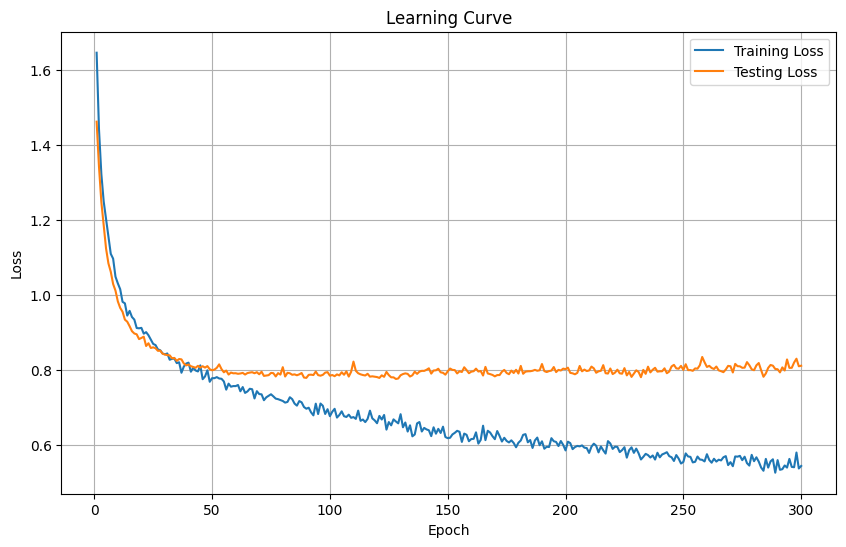

In [9]:
model_train(model, criterion, optimizer, train_loader, test_loader, epochs=300)

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       173
           1       0.62      0.71      0.66       206
           2       0.76      0.69      0.72       188
           3       0.80      0.78      0.79       120
           4       0.72      0.73      0.72       122
           5       0.77      0.62      0.68       133

    accuracy                           0.73       942
   macro avg       0.74      0.73      0.73       942
weighted avg       0.73      0.73      0.73       942



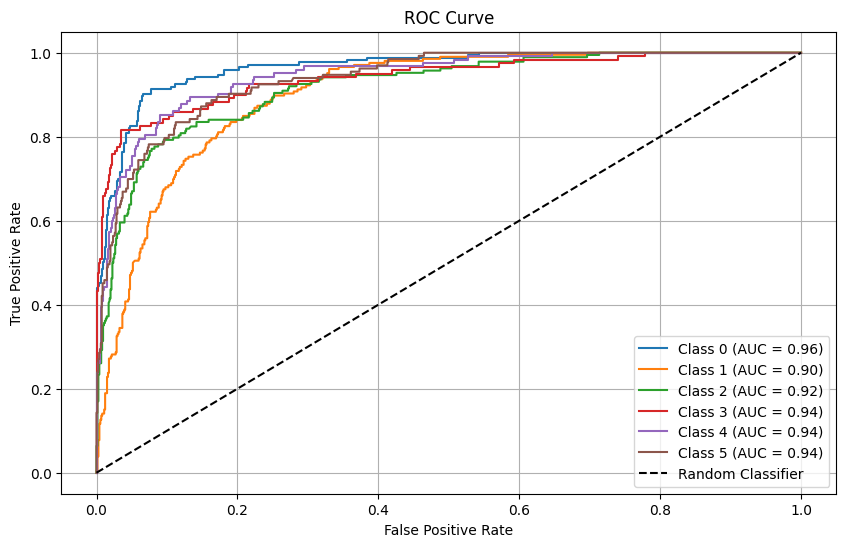

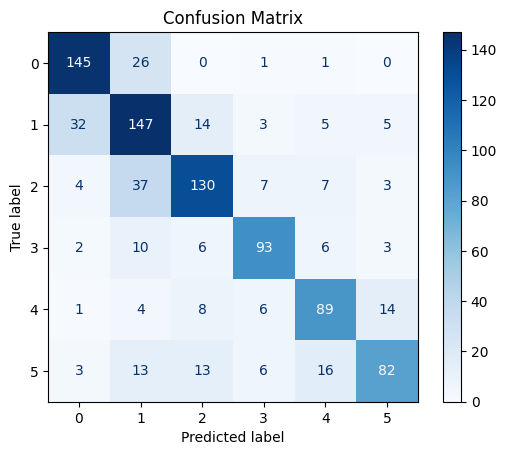

In [10]:
evaluate_model(model, test_loader)

## Let's try balancing with smote

In [11]:
y_train.value_counts()

Target
1    823
2    750
0    691
5    532
4    488
3    481
Name: count, dtype: int64

In [12]:
from imblearn.over_sampling import SMOTE

# Initializing smote
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
y_train_resampled.value_counts()

Target
0    823
1    823
5    823
2    823
3    823
4    823
Name: count, dtype: int64

In [13]:
# Converting to PyTorch tensors
X_train_resampled_tensor = torch.tensor(X_train_resampled.values, dtype=torch.float32)
y_train_resampled_tensor = torch.tensor(y_train_resampled.values, dtype=torch.long)


In [14]:
# Data prepration for PyTorch

from torch.utils.data import DataLoader, TensorDataset

# Combine embeddings and labels into TensorDataset
train_dataset_resampled = TensorDataset(X_train_resampled_tensor, y_train_resampled_tensor)
# test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoader for batching
train_loader_resampled = DataLoader(train_dataset_resampled, batch_size=32, shuffle=True)  # Batch size adjustable
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
# Balanced training

model2 = DNN_Classifier(input_dim, output_dim)

# loss function and Adam Optimizer
criterion2 = nn.CrossEntropyLoss()  # For multi-class classification
optimizer2 = optim.Adam(model2.parameters(), lr=0.0001 )  # Adam optimizer



Epoch 1/300, Train Loss: 1.6353, Test Loss: 1.4848
Epoch 2/300, Train Loss: 1.4284, Test Loss: 1.3409
Epoch 3/300, Train Loss: 1.3030, Test Loss: 1.2390
Epoch 4/300, Train Loss: 1.2186, Test Loss: 1.1871
Epoch 5/300, Train Loss: 1.1475, Test Loss: 1.1334
Epoch 6/300, Train Loss: 1.1041, Test Loss: 1.0926
Epoch 7/300, Train Loss: 1.0730, Test Loss: 1.0411
Epoch 8/300, Train Loss: 1.0416, Test Loss: 1.0125
Epoch 9/300, Train Loss: 1.0153, Test Loss: 0.9943
Epoch 10/300, Train Loss: 0.9785, Test Loss: 0.9631
Epoch 11/300, Train Loss: 0.9618, Test Loss: 0.9594
Epoch 12/300, Train Loss: 0.9429, Test Loss: 0.9347
Epoch 13/300, Train Loss: 0.9192, Test Loss: 0.9188
Epoch 14/300, Train Loss: 0.9084, Test Loss: 0.9105
Epoch 15/300, Train Loss: 0.8997, Test Loss: 0.9049
Epoch 16/300, Train Loss: 0.8985, Test Loss: 0.8975
Epoch 17/300, Train Loss: 0.8699, Test Loss: 0.8874
Epoch 18/300, Train Loss: 0.8593, Test Loss: 0.8806
Epoch 19/300, Train Loss: 0.8532, Test Loss: 0.8800
Epoch 20/300, Train L

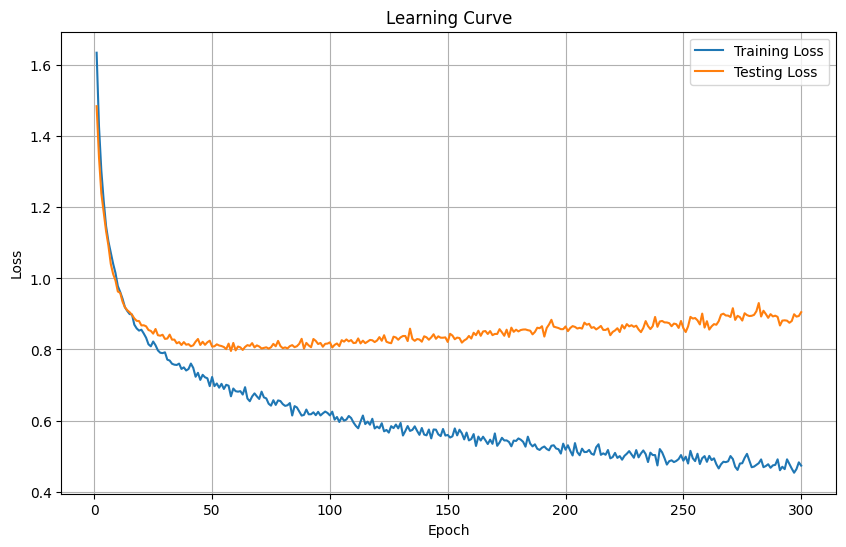

In [15]:
model_train(model2, criterion2, optimizer2, train_loader_resampled, test_loader, epochs=300)

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.76      0.79       173
           1       0.61      0.71      0.65       206
           2       0.71      0.70      0.71       188
           3       0.72      0.77      0.74       120
           4       0.73      0.68      0.70       122
           5       0.76      0.63      0.69       133

    accuracy                           0.71       942
   macro avg       0.72      0.71      0.71       942
weighted avg       0.72      0.71      0.71       942



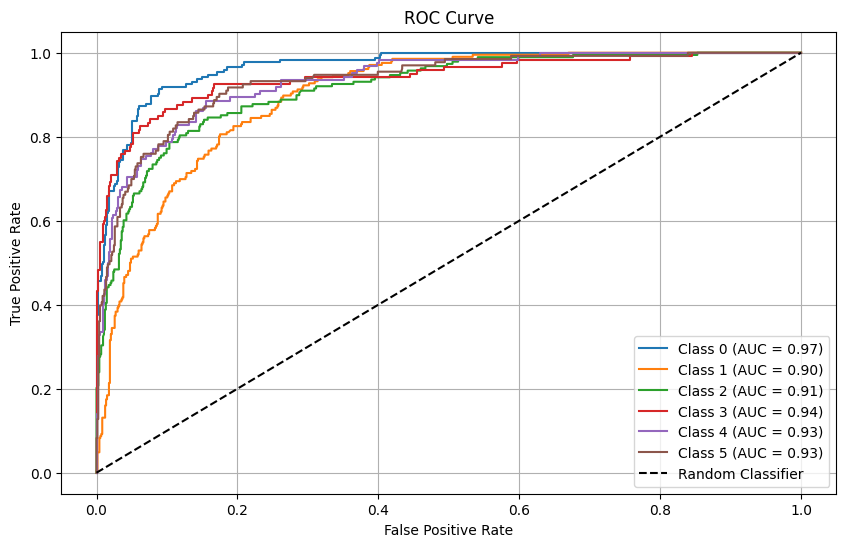

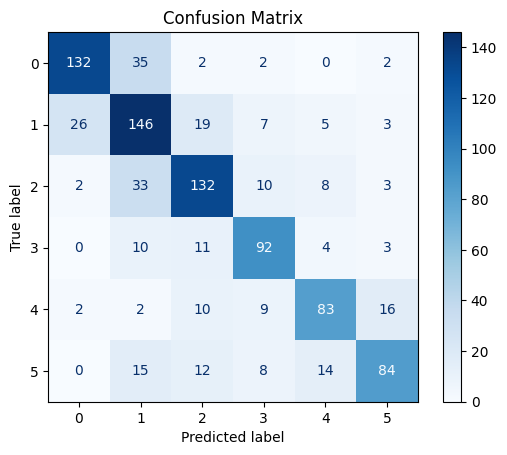

In [16]:
evaluate_model(model2, test_loader)

## SMOTE

In [17]:
from imblearn.over_sampling import SMOTE

# Initializing smote
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
y_resampled.value_counts()

Target
0    1029
1    1029
2    1029
4    1029
3    1029
5    1029
Name: count, dtype: int64

In [18]:
from sklearn.model_selection import train_test_split

X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_resampled, y_resampled, test_size=0.2,shuffle=True, stratify=y_resampled, random_state=42)

# Converting to PyTorch tensors
X_train_smote_tensor = torch.tensor(X_train_smote.values, dtype=torch.float32)
X_test_smote_tensor = torch.tensor(X_test_smote.values, dtype=torch.float32)
y_train_smote_tensor = torch.tensor(y_train_smote.values, dtype=torch.long)
y_test_smote_tensor = torch.tensor(y_test_smote.values, dtype=torch.long)


In [19]:
# Combine embeddings and labels into TensorDataset
train_smote_dataset = TensorDataset(X_train_smote_tensor, y_train_smote_tensor)
test_smote_dataset = TensorDataset(X_test_smote_tensor, y_test_smote_tensor)

# Create DataLoader for batching
train_smote_loader = DataLoader(train_smote_dataset, batch_size=32, shuffle=True)  # Batch size adjustable
test_smote_loader = DataLoader(test_smote_dataset, batch_size=32, shuffle=False)

Epoch 1/300, Train Loss: 1.6294, Test Loss: 1.4228
Epoch 2/300, Train Loss: 1.3822, Test Loss: 1.2966
Epoch 3/300, Train Loss: 1.2675, Test Loss: 1.1980
Epoch 4/300, Train Loss: 1.1953, Test Loss: 1.1340
Epoch 5/300, Train Loss: 1.1400, Test Loss: 1.0707
Epoch 6/300, Train Loss: 1.0826, Test Loss: 1.0374
Epoch 7/300, Train Loss: 1.0498, Test Loss: 1.0025
Epoch 8/300, Train Loss: 1.0144, Test Loss: 0.9645
Epoch 9/300, Train Loss: 0.9786, Test Loss: 0.9484
Epoch 10/300, Train Loss: 0.9528, Test Loss: 0.9285
Epoch 11/300, Train Loss: 0.9490, Test Loss: 0.9179
Epoch 12/300, Train Loss: 0.9287, Test Loss: 0.8878
Epoch 13/300, Train Loss: 0.9190, Test Loss: 0.8844
Epoch 14/300, Train Loss: 0.9099, Test Loss: 0.8725
Epoch 15/300, Train Loss: 0.8918, Test Loss: 0.8593
Epoch 16/300, Train Loss: 0.8673, Test Loss: 0.8503
Epoch 17/300, Train Loss: 0.8724, Test Loss: 0.8442
Epoch 18/300, Train Loss: 0.8511, Test Loss: 0.8320
Epoch 19/300, Train Loss: 0.8345, Test Loss: 0.8377
Epoch 20/300, Train L

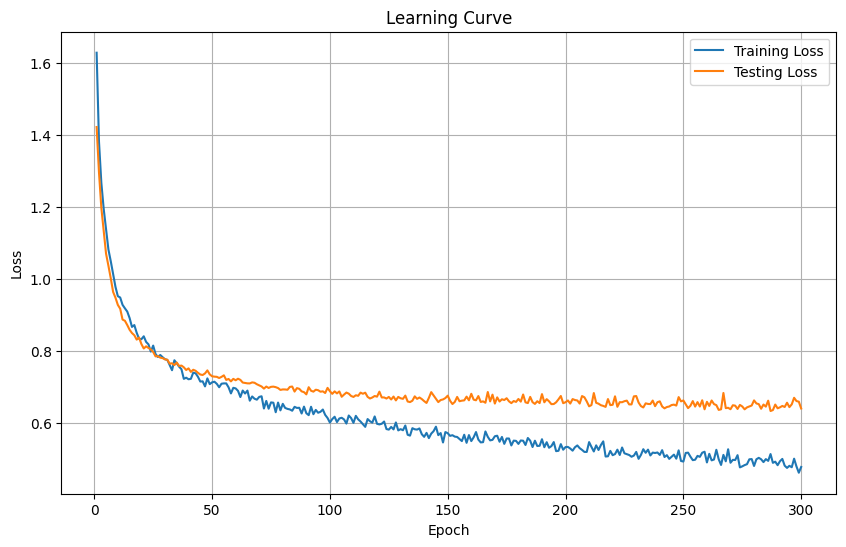

In [20]:
model3 = DNN_Classifier(input_dim, output_dim)

# loss function and Adam Optimizer
criterion3 = nn.CrossEntropyLoss()  # For multi-class classification
optimizer3 = optim.Adam(model3.parameters(), lr=0.0001 )  # Adam optimizer

model_train(model3, criterion3, optimizer3, train_smote_loader, test_smote_loader, epochs=300)

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       205
           1       0.62      0.70      0.66       206
           2       0.72      0.67      0.69       206
           3       0.90      0.87      0.88       206
           4       0.82      0.84      0.83       206
           5       0.84      0.71      0.77       206

    accuracy                           0.78      1235
   macro avg       0.78      0.78      0.78      1235
weighted avg       0.78      0.78      0.78      1235



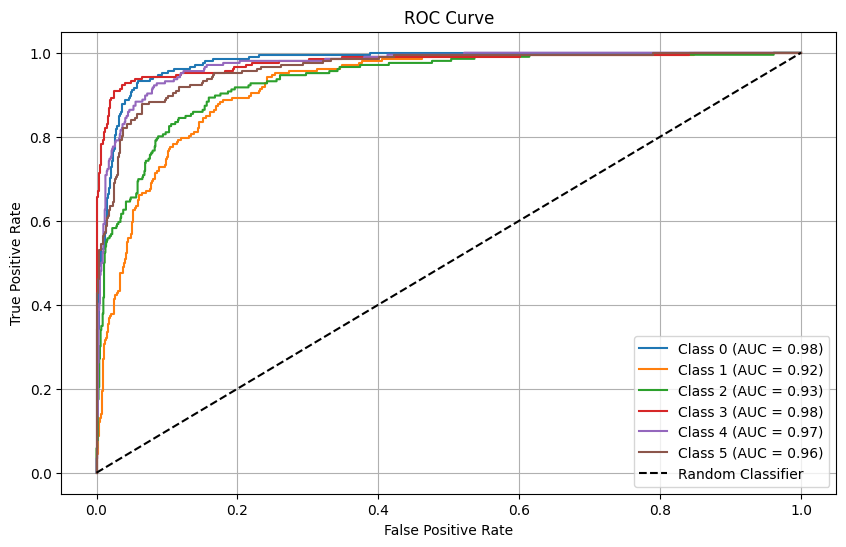

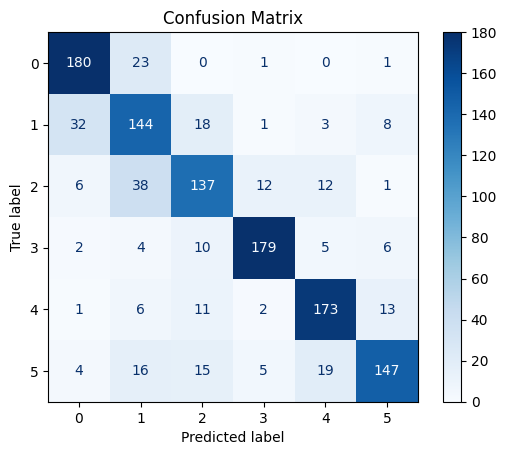

In [21]:
evaluate_model(model3, test_smote_loader)

## Let's try cost sensitive

In [22]:
from sklearn.utils.class_weight import compute_class_weight

model4 = DNN_Classifier(input_dim, output_dim)

# Getting Class Weights
y_train_np = y_train.to_numpy()

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',  # Automatically balances based on class frequencies
    classes=np.unique(y_train_np),  # Unique classes in training labels
    y=y_train_np  # Training labels
)
class_weights = class_weights / np.sum(class_weights) # Normalizing magnitude for proper gradient updates

# Convert class weights to a PyTorch tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)
print("Normalized Class Weights:", class_weights_tensor)

# Now passing these weight to loss function
criterion4 = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer4 = torch.optim.Adam(model4.parameters(), lr=0.0001) # Reduced from 0.001


Normalized Class Weights: tensor([0.1447, 0.1215, 0.1333, 0.2078, 0.2048, 0.1879])


Epoch 1/300, Train Loss: 1.7129, Test Loss: 1.5220
Epoch 2/300, Train Loss: 1.4783, Test Loss: 1.3677
Epoch 3/300, Train Loss: 1.3519, Test Loss: 1.2789
Epoch 4/300, Train Loss: 1.2698, Test Loss: 1.2193
Epoch 5/300, Train Loss: 1.2272, Test Loss: 1.1652
Epoch 6/300, Train Loss: 1.1688, Test Loss: 1.1350
Epoch 7/300, Train Loss: 1.1243, Test Loss: 1.0994
Epoch 8/300, Train Loss: 1.0885, Test Loss: 1.0770
Epoch 9/300, Train Loss: 1.0673, Test Loss: 1.0412
Epoch 10/300, Train Loss: 1.0509, Test Loss: 1.0179
Epoch 11/300, Train Loss: 1.0304, Test Loss: 1.0035
Epoch 12/300, Train Loss: 0.9950, Test Loss: 0.9788
Epoch 13/300, Train Loss: 0.9838, Test Loss: 0.9736
Epoch 14/300, Train Loss: 0.9716, Test Loss: 0.9632
Epoch 15/300, Train Loss: 0.9542, Test Loss: 0.9473
Epoch 16/300, Train Loss: 0.9543, Test Loss: 0.9297
Epoch 17/300, Train Loss: 0.9375, Test Loss: 0.9238
Epoch 18/300, Train Loss: 0.9387, Test Loss: 0.9214
Epoch 19/300, Train Loss: 0.9344, Test Loss: 0.9137
Epoch 20/300, Train L

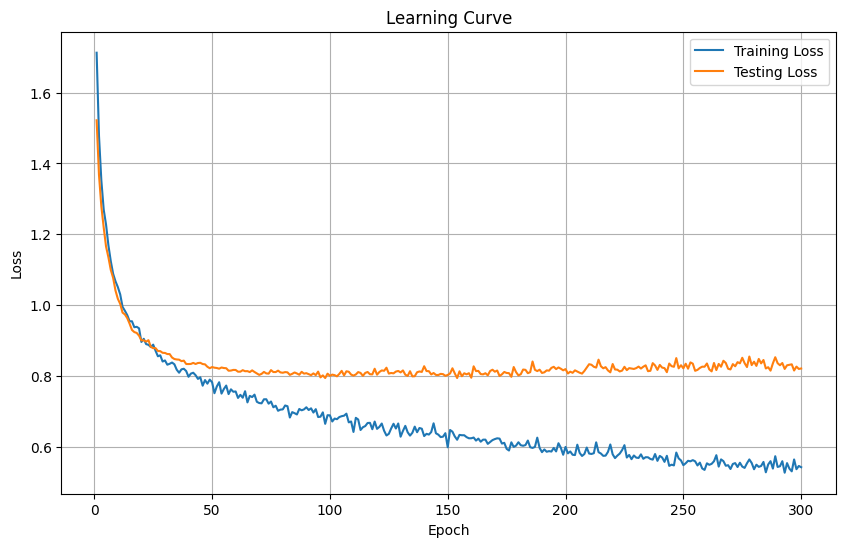

In [23]:
model_train(model4, criterion4, optimizer4, train_loader, test_loader, epochs=300)

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       173
           1       0.61      0.69      0.65       206
           2       0.72      0.70      0.71       188
           3       0.79      0.75      0.77       120
           4       0.66      0.71      0.69       122
           5       0.73      0.62      0.67       133

    accuracy                           0.71       942
   macro avg       0.72      0.71      0.71       942
weighted avg       0.71      0.71      0.71       942



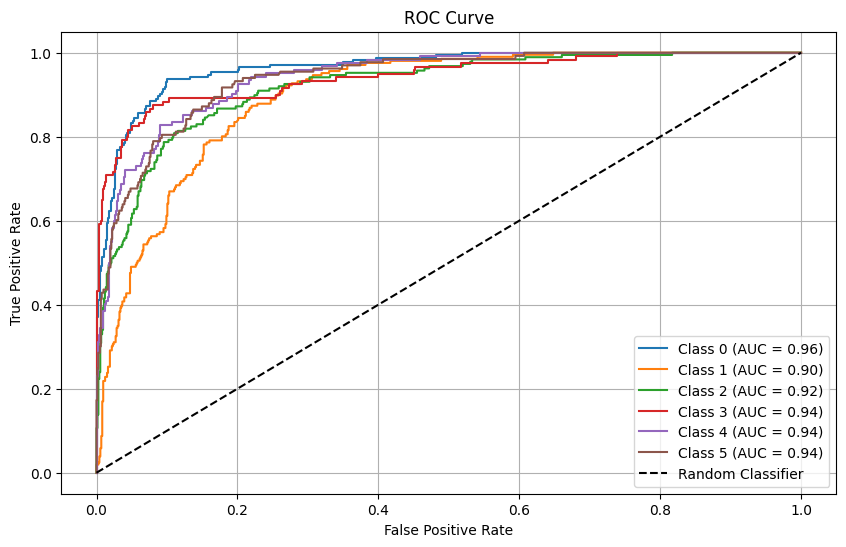

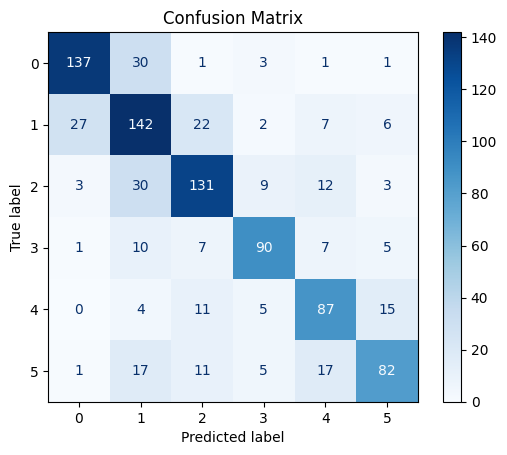

In [24]:
evaluate_model(model4, test_loader)